# Sokołowski et al. 2024

[Sokołowski, Andrzej, et al. "Longitudinal brain structure changes in Parkinson’s disease: A replication study." Plos one 19.1 (2024): e0295069.](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0295069)

## Demographics

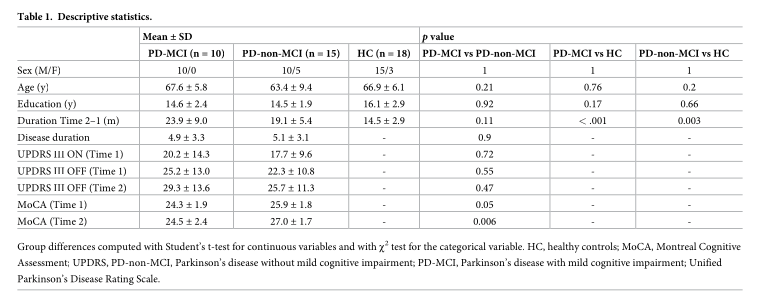

### Results

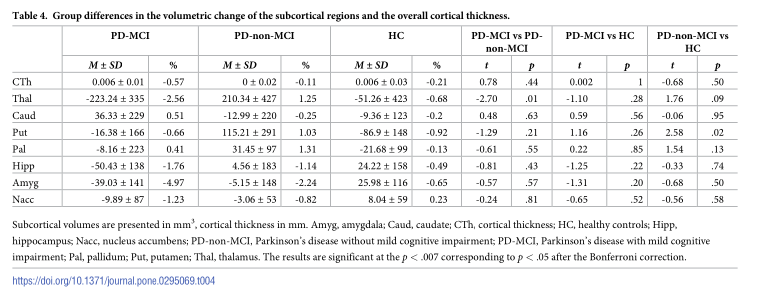

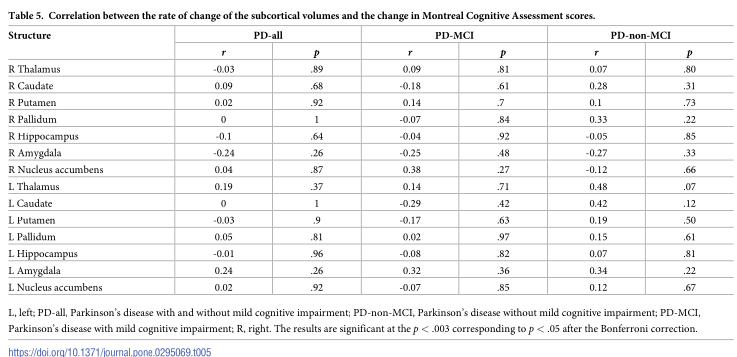

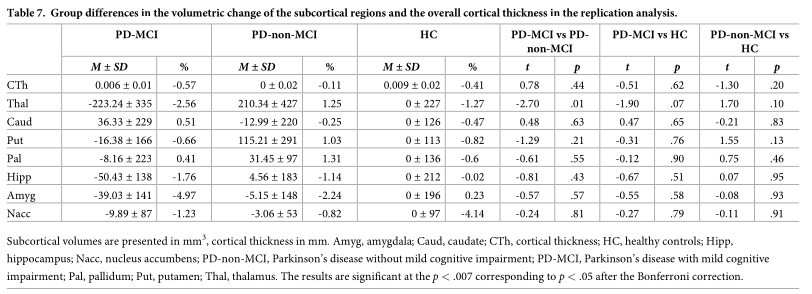

## Consistency

In [63]:
import pandas as pd
from pathlib import Path
from IPython.display import Image

anonymizer = True

root_dir = Path().cwd().parent.parent.parent.parent.resolve()

def anondir(path: Path, prefix=root_dir) -> Path:
    """Anonymize a directory path by replacing user-specific parts with <root>."""
    if not anonymizer:
        return path
    path_str = str(path).replace(str(prefix), "<living-park>")
    return Path(path_str)


print(f"Running in root dir: {anondir(root_dir)}")
npv_dir = root_dir / "npv" / "csv_all"
assert npv_dir.exists(), f"NPV dir does not exist: {anondir(npv_dir)}"
print(f"Using NPV dir: {anondir(npv_dir)}")
data_dir = root_dir / "notebooks" / "papers_data" / "parkinson" / "Sokolowski_2024_2"
assert data_dir.exists(), f"Data dir does not exist: {anondir(data_dir)}"
print(f"Using data dir: {anondir(data_dir)}")
figure_dir = root_dir / "figures"
figure_dir.mkdir(parents=True, exist_ok=True)
assert figure_dir.exists(), f"Figure dir does not exist: {anondir(figure_dir)}"
print(f"Using figure dir: {anondir(figure_dir)}")

Running in root dir: <living-park>
Using NPV dir: <living-park>/npv/csv_all
Using data dir: <living-park>/notebooks/papers_data/parkinson/Sokolowski_2024_2
Using figure dir: <living-park>/figures


### Load NPV maps

In [64]:
npv_thickness_long = pd.read_csv(
    npv_dir / "npv_hc-pd_thickness_bilateral_longitudinal.csv"
)
npv_subcortical_volume_long = pd.read_csv(
    npv_dir / "npv_hc-pd_subcortical_volume_bilateral_longitudinal.csv"
)
npv_bil_long = pd.concat([npv_thickness_long, npv_subcortical_volume_long])
npv_bil_long.drop(columns=["hemisphere"], inplace=True)

npv_subcortical_volume_long = pd.read_csv(
    npv_dir / "npv_hc-pd_subcortical_volume_longitudinal.csv"
)

### Formula

In [65]:
import numpy as np
import scipy.stats


# T-test
def std_t(npv):
    return npv


def std_p_t(t, df, npv):
    return 2 * scipy.stats.t.pdf(np.abs(t), df) * npv


# F-test
def std_F(F, npv):
    return 2 * np.sqrt(F) * npv


def std_p_F(F, n, navr):
    return 2 * np.sqrt(F) * scipy.stats.f.pdf(F, dfn=1, dfd=n - 2) * navr


# Partial correlation
def std_r(r, n, npv):
    return ((1 - r**2) ** 3 / (n - 1)) ** 0.5 * npv


def std_p_r(r, n, npv):
    t = r * ((n - 2) / (1 - r**2)) ** 0.5
    return 2 * scipy.stats.t.pdf(np.abs(t), n - 2) * np.sqrt((n - 2) / (n - 1)) * npv

In [66]:
import pandas as pd
from scipy.stats import beta
import numpy as np


def beta_params_from_mean_var(mu, var, eps=1e-12):
    """Return (a,b) for Beta by moment matching. Clamps var to < mu(1-mu)."""
    max_var = mu * (1 - mu) - eps
    # Clamp var for non-degenerate cases
    var_clamped = np.minimum(var, max_var)

    # Calculate k for non-degenerate cases
    # Ensure we don't divide by zero if var_clamped becomes zero due to clamping
    # This can happen if mu*(1-mu) is very small and var is also very small but positive.
    # The original code implicitly handles this by setting k=1e6 when var<=0.
    # Here, we ensure that if var_clamped is effectively zero, k is large.
    # A small positive value for the denominator to avoid division by zero for k calculation
    denominator = np.where(var_clamped == 0, eps, var_clamped)
    k_calculated = mu * (1 - mu) / denominator - 1.0
    # Ensure k is not negative, as it should be > 0 for Beta distribution
    k_calculated = np.maximum(k_calculated, eps)  # k must be > 0

    a_calculated = mu * k_calculated
    b_calculated = (1 - mu) * k_calculated
    return a_calculated, b_calculated


def flip_proba_beta(p0, sigma_P, alpha=0.05):
    """
    Flip probability at alpha with P ~ Beta(a,b).
    Provide either sigma_P.
    Works with pandas Series/DataFrames.
    """
    var_P = sigma_P**2
    a, b = beta_params_from_mean_var(p0, var_P)

    # Determine the flip probability based on p0 relative to alpha
    # Use np.where for vectorized conditional logic
    # pflip_non_significant = 1.0 - beta.cdf(alpha, a, b) # if p0 < alpha, flip if P > alpha
    pflip_significant = beta.cdf(alpha, a, b)  # if p0 >= alpha, flip if P <= alpha

    # pflip = np.where(p0 < alpha, pflip_significant, pflip_non_significant)
    pflip = pflip_significant
    pflip = np.where(np.isnan(pflip), 0.0, pflip)
    

    # Clip the result to ensure it's within [0, 1]
    return np.clip(pflip, 0.0, 1.0)

In [67]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd


def plot_dumbbell(results, title, alpha):
    df = results.copy()
    df.rename(
        columns={
            "std_p": "std_p",
            "std_r": "std_r",
            "sig": "sig",
            "p": "p_value",
            "std_p_low": "std_p_low",
            "std_p_high": "std_p_high",
            "proba_significant": "psig",
        },
        inplace=True,
    )
    df["std_p_low"] = df["std_p"] - df["std_p_low"]
    df["std_p_high"] = df["std_p_high"] - df["std_p"]

    col_label = "std_p"

    fig = make_subplots(
        rows=1,
        cols=3,
        subplot_titles=["p-value", "std p-value", "Probability significance"],
    )

    fig_1 = px.scatter(df, x="region", y="p_value", color="group")
    # Add lines for each dumbbell
    fig_2 = px.scatter(
        df,
        x="region",
        y="std_p",
        color="group",
        error_y="std_p_low",
        error_y_minus="std_p_high",
        labels="std_p",
    )
    fig_3 = go.Scatter(
        x=df["region"],
        y=df["psig"],
        mode="markers",
        marker_color="black",
        marker_symbol="cross",
        name="Flip probability",
        showlegend=False,
    )

    fig.add_traces(fig_1.data, rows=1, cols=1)
    fig.add_traces(fig_2.data, rows=1, cols=2)
    fig.add_traces(fig_3, rows=1, cols=3)

    fig.update_layout(
        title=title,
        yaxis_title=col_label,
        xaxis_title="Value",
        hovermode="closest",
        height=600,
        width=1400,
    )

    fig.add_hline(y=alpha, line_color="red", line_width=2, row=1, col=1)
    fig.update_yaxes(range=[-0.05, 1.05])

    return fig

## Consistency analysis

### Table 4 - Group differences

In [68]:
df = pd.read_csv(data_dir / "table_4.csv")
n_hc = 18
n_pd_mci = 10
n_pd_non_mci = 15
n_all = n_hc + n_pd_mci + n_pd_non_mci
df = df.melt(id_vars=["region"], var_name="metric", value_name="value")
df[["group", "stat"]] = df.metric.str.split("_", expand=True)
df.drop(columns=["metric"], inplace=True)
df = df[df["group"].str.contains("vs")]
df = df.pivot_table(
    index=["region", "group"], columns="stat", values="value"
).reset_index()
df[["group1", "group2"]] = df.group.str.split("-vs-", expand=True)
df["n_1"] = df["group1"].map(
    {"PD-MCI": n_pd_mci, "PD-non-MCI": n_pd_non_mci, "HC": n_hc}
)
df["n_2"] = df["group2"].map(
    {"PD-MCI": n_pd_mci, "PD-non-MCI": n_pd_non_mci, "HC": n_hc}
)
df = pd.merge(df, npv_bil_long, on="region")
df["metric"] = "subcortical volume"
df[df["region"] == "MeanThicknes"]["metric"] = "cortical thickness"
df["test"] = "T"
df["sample_size"] = df["n_1"] + df["n_2"]
df["std_t"] = df["npv"]
df["std_p"] = std_p_t(df["t"], df["n_1"] + df["n_2"] - 2, df["npv"])
df["std_p_low"] = std_p_t(df["t"], df["n_1"] + df["n_2"] - 2, df["npv_CI_low"])
df["std_p_high"] = std_p_t(df["t"], df["n_1"] + df["n_2"] - 2, df["npv_CI_high"])
df["alpha"] = 0.007
df["proba_significant"] = flip_proba_beta(df["p"], df["std_p"], alpha=0.007)
df["significant"] = df["p"] < 0.007  # Bonferroni correction

df.rename(columns={"p": "p_value"}, inplace=True)
df_t4 = df.copy()

In [69]:
plot_dumbbell(df_t4, "Group differences", alpha=0.007)

### Table 5 - Partial Correlation

In [70]:
df = pd.read_csv(data_dir / "table_5.csv")
n_hc = 18
n_pd_mci = 10
n_pd_non_mci = 15
n_pd_all = n_pd_mci + n_pd_non_mci
n_all = n_hc + n_pd_mci + n_pd_non_mci
df = df.melt(id_vars=["region"], var_name="metric", value_name="value")
df[["group", "stat"]] = df.metric.str.split("_", expand=True)
df.drop(columns=["metric"], inplace=True)
df = df.pivot_table(
    index=["region", "group"], columns="stat", values="value"
).reset_index()
df["n_1"] = df["group"].map(
    {"PD-all": n_pd_all, "PD-MCI": n_pd_mci, "PD-non-MCI": n_pd_non_mci, "HC": n_hc}
)
df = pd.merge(df, npv_subcortical_volume_long, on="region")
df["metric"] = "subcortical volume"
df["test"] = "R"
df["sample_size"] = df["n_1"]
df["std_r"] = df["npv"]
df["std_p"] = std_p_r(df["r"], df["n_1"] - 2, df["npv"])
df["std_p_low"] = std_p_r(df["r"], df["n_1"] - 2, df["npv_CI_low"])
df["std_p_high"] = std_p_r(df["r"], df["n_1"] - 2, df["npv_CI_high"])
df["alpha"] = 0.003
df["proba_significant"] = flip_proba_beta(df["p"], df["std_p"], alpha=0.003)
df["significant"] = df["p"] < 0.003  # Bonferroni correction

df.rename(columns={"p": "p_value"}, inplace=True)
df_t5 = df.copy()

In [71]:
plot_dumbbell(df_t5, "Partial correlation", alpha=0.003)

### Table 7 - Group differences replication

In [72]:
df = pd.read_csv(data_dir / "table_7.csv")
n_hc = 18
n_pd_mci = 10
n_pd_non_mci = 15
n_all = n_hc + n_pd_mci + n_pd_non_mci
df = df.melt(id_vars=["region"], var_name="metric", value_name="value")
df[["group", "stat"]] = df.metric.str.split("_", expand=True)
df.drop(columns=["metric"], inplace=True)
df = df[df["group"].str.contains("vs")]
df = df.pivot_table(
    index=["region", "group"], columns="stat", values="value"
).reset_index()
df[["group1", "group2"]] = df.group.str.split("-vs-", expand=True)
df["n_1"] = df["group1"].map(
    {"PD-MCI": n_pd_mci, "PD-non-MCI": n_pd_non_mci, "HC": n_hc}
)
df["n_2"] = df["group2"].map(
    {"PD-MCI": n_pd_mci, "PD-non-MCI": n_pd_non_mci, "HC": n_hc}
)
df = pd.merge(df, npv_bil_long, on="region")
df["metric"] = "subcortical volume"
df[df["region"] == "MeanThicknes"]["metric"] = "cortical thickness"
df["test"] = "T"
df["sample_size"] = df["n_1"] + df["n_2"]
df["std_t"] = df["npv"]
df["std_p"] = std_p_t(df["t"], df["n_1"] + df["n_2"] - 2, df["npv"])
df["std_p_low"] = std_p_t(df["t"], df["n_1"] + df["n_2"] - 2, df["npv_CI_low"])
df["std_p_high"] = std_p_t(df["t"], df["n_1"] + df["n_2"] - 2, df["npv_CI_high"])
df['alpha'] = 0.007
df["proba_significant"] = flip_proba_beta(df["p"], df["std_p"], alpha=0.007)
df["significant"] = df["p"] < 0.007  # Bonferroni correction

df.rename(columns={"p": "p_value"}, inplace=True)
df_t7 = df.copy()

In [73]:
plot_dumbbell(df_t7, "Group differences (replication)", alpha=0.007)

In [74]:
df_t4["analysis"] = "table_4"
df_t5["analysis"] = "table_5"
df_t7["analysis"] = "table_7"

df = pd.concat([df_t4, df_t5, df_t7])
df["study"] = "longitudinal"
# Assert dataframe contains "proba_significant" and "significant" columns
assert "p_value" in df.columns
assert "proba_significant" in df.columns
assert "significant" in df.columns
assert "sample_size" in df.columns
assert "test" in df.columns
assert "metric" in df.columns
assert "study" in df.columns
df.to_csv(data_dir / "uncertainty.csv", index=False)